In [48]:
import numpy as np
import pandas as pd
import glob

In [49]:
list = glob.glob("*.csv")
list

['us-counties.csv',
 'time_series_covid19_confirmed_global.csv',
 'us-states.csv',
 'us.csv']

In [50]:
data_pre = pd.read_csv("us-counties.csv", parse_dates = ["date"])
data = data_pre.query('cases <= 300')

In [51]:
data.describe()

,fips,cases,deaths
count,55867.000000,56513.000000,56513.000000
mean,29671.609644,22.566188,0.625060
std,15575.722075,44.575193,4.434328
min,1001.000000,0.000000,0.000000
25%,17195.000000,2.000000,0.000000
50%,28145.000000,5.000000,0.000000
75%,45011.000000,19.000000,0.000000
max,56043.000000,300.000000,678.000000


In [52]:
data_pre["level_cases"] = pd.cut(data_pre.cases, 3, labels=[0, 1, 2])

In [53]:
data_pre.head()

,date,county,state,fips,cases,deaths,level_cases
0,2020-01-21,Snohomish,Washington,53061.0,1,0,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0,0
3,2020-01-24,Cook,Illinois,17031.0,1,0,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0,0


In [54]:
from sklearn.preprocessing import MinMaxScaler
cl = MinMaxScaler()
X_t = cl.fit_transform(data[["cases"]])
data["cases_norm"] = X_t

/Users/fatmimi/opt/anaconda3/envs/playground/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [55]:
county = data.groupby("county").get_group("Teton")
county.describe()

,fips,cases,deaths,cases_norm
count,60.000000,60.000000,60.0,60.000000
mean,34728.066667,13.533333,0.0,0.045111
std,20102.779838,17.778741,0.0,0.059262
min,16081.000000,1.000000,0.0,0.003333
25%,16081.000000,2.000000,0.0,0.006667
50%,16081.000000,4.500000,0.0,0.015000
75%,56039.000000,18.500000,0.0,0.061667
max,56039.000000,57.000000,0.0,0.190000


In [58]:
#creating windows
def create_window(interval, data):
    X = []
    y = []
    groupby_county = data.groupby("county")
    county_list = data.county.unique()
    for county_ind in county_list:
        county = groupby_county.get_group(county_ind)
        for i in range(county.shape[0]-interval-5):
            X.append(county.cases_norm.iloc[i:i+interval])
            y.append(county.cases_norm.iloc[i+interval:i+interval+5])
    X= np.array(X)
    y = np.array(y)
    return X, y

In [59]:
interval = 5
data_X, data_y = create_window(interval,data)

In [60]:
data_y.shape

(40829, 5)

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=42)


In [62]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
#temporal input branch
input_layer = Input(shape=(5,1))
lstm_layer_1 = layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)(input_layer)
dense_layer = layers.Dense(64)(lstm_layer_1)
#dropout_layer = layers.Dropout(dense_layer)
covid_cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="cases")(dense_layer)

#Establish model
model = Model([input_layer], [covid_cases])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5, 1)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
dense_6 (Dense)              (None, 5, 64)             8256      
_________________________________________________________________
cases (Dense)                (None, 5, 1)              65        
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [64]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [65]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [66]:
model_2 = Sequential()
model_2.add(layers.LSTM(128,input_shape=(interval,1)))
model_2.add(layers.Dense(64))
model_2.add(layers.Dropout(rate = 0.2))
model_2.add(layers.Dense(5))

In [67]:
model_2.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam')

In [68]:
history = model_2.fit(X_train, y_train, 
          epochs = 30, 
          batch_size = 1000, 
          validation_data=(X_test,  y_test), 
          callbacks=callbacks)

Train on 27355 samples, validate on 13474 samples
Epoch 1/30
27355/27355 [==============================] - 3s 110us/sample - loss: 0.0111 - val_loss: 0.0091
Epoch 2/30
27355/27355 [==============================] - 1s 43us/sample - loss: 0.0092 - val_loss: 0.0090
Epoch 3/30
27355/27355 [==============================] - 1s 44us/sample - loss: 0.0091 - val_loss: 0.0090
Epoch 4/30
27355/27355 [==============================] - 1s 44us/sample - loss: 0.0091 - val_loss: 0.0090
Epoch 5/30
27355/27355 [==============================] - 1s 45us/sample - loss: 0.0090 - val_loss: 0.0089
Epoch 6/30
27355/27355 [==============================] - 1s 45us/sample - loss: 0.0090 - val_loss: 0.0089
Epoch 7/30
27000/27355 [============================>.] - ETA: 0s - loss: 0.0090
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
27355/27355 [==============================] - 1s 52us/sample - loss: 0.0089 - val_loss: 0.0089
Epoch 8/30
27355/27355 [==========================

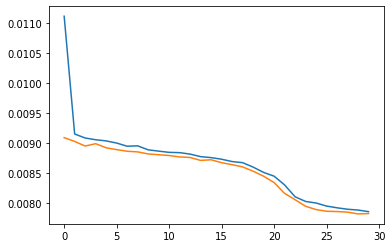

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

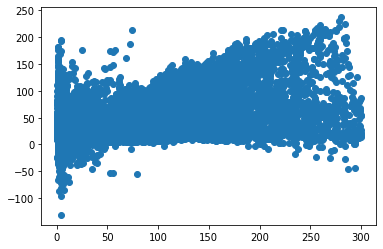

In [70]:
Xt = model_2.predict(X_test)
plt.scatter(cl.inverse_transform(y_test.reshape(-1,1)),cl.inverse_transform(Xt))

In [71]:
#Prepare Alachua data
Alachua = data_pre.groupby('county').get_group('Alachua')
c = Alachua.cases[-interval:].values.reshape(-1,1)
Alachua_cases = cl.transform(c)
alas = Alachua_cases.reshape(1,interval,1)
Ala = model_2.predict(alas)
Ala_rev = cl.inverse_transform(Ala).reshape(5)
Ala_rev

array([161.92361, 188.72038, 190.11728, 206.7797 , 213.25244],
      dtype=float32)

In [72]:
r = [1,2,3,4,5]
for s in zip(r, Ala_rev):
    print([s[0],s[1]])

[1, 161.92361]
[2, 188.72038]
[3, 190.11728]
[4, 206.7797]
[5, 213.25244]


In [73]:
a = data_pre.query("county == 'Alachua'")

In [74]:
import datetime
day = []
for i in range(0,5):
    n = a.date.iloc[-1] + datetime.timedelta(days=i)
    day.append(n)
day

[Timestamp('2020-04-14 00:00:00'),
 Timestamp('2020-04-15 00:00:00'),
 Timestamp('2020-04-16 00:00:00'),
 Timestamp('2020-04-17 00:00:00'),
 Timestamp('2020-04-18 00:00:00')]

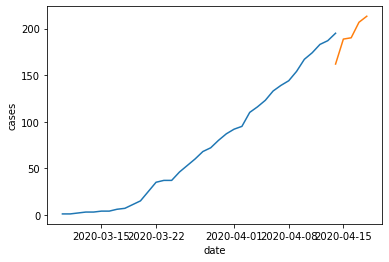

In [75]:
sns.lineplot(a.date, a.cases)
sns.lineplot(day,Ala_rev.reshape(5))